Chart hospitalizations from COVID-19 in Ottawa.

Richard Akerman

December 31, 2021

Code developed in Google Colaboratory will be posted to GitHub (scilib) with MIT License.

Code uses examples and techniques from:

*   Data to Fish - [How to Select Rows from Pandas DataFrame](https://datatofish.com/select-rows-pandas-dataframe/)
*   [matplotlib.pyplot.bar](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html)
*   Stack Overflow - Python - [Get list from pandas dataframe column or row?](https://stackoverflow.com/questions/22341271/get-list-from-pandas-dataframe-column-or-row)
*   tutorialspoint - [Matplotlib - Bar Plot](https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm)
*   Geeks for Geeks - [Plotting multiple bar charts using Matplotlib in Python](https://www.geeksforgeeks.org/plotting-multiple-bar-charts-using-matplotlib-in-python/)
*Geeks for Geeks - [Matplotlib.pyplot.colors() in Python](https://www.geeksforgeeks.org/matplotlib-pyplot-colors-in-python/)
*   Google - [Charting in Colaboratory](https://colab.research.google.com/notebooks/charts.ipynb)
*   towards data science (subscription) - [Pretty displaying tricks for columnar data in Python](https://towardsdatascience.com/pretty-displaying-tricks-for-columnar-data-in-python-2fe3b3ed9b83)
*  DelftStack - [Hide Axis Text Ticks and/or Tick Labels in Matplotlib](https://www.delftstack.com/howto/matplotlib/how-to-hide-axis-text-ticks-and-or-tick-labels-in-matplotlib/)

Data from Ontario open data - [COVID-19 cases in hospital and ICU, by Ontario Health (OH) region](https://data.ontario.ca/en/dataset/covid-19-cases-in-hospital-and-icu-by-ontario-health-region)

This is rows labeled by region, EAST is the one this code uses.

Verified that East is the correct region for Ottawa, see e.g. [Ontario Public Health Units and Health Unit Regions](https://www.researchgate.net/figure/Ontario-public-health-units-and-health-unit-regions_fig1_322667994)

Note that what is plotted for ICU is cases that are currently testing positive for COVID-19, not total cases, due to some historical issues with the dataset.

TODO: Label chart with dates

Caveats: Will break if data URL changes or if data format changes.

September 28, 2023

It looks like data.ontario.ca is now checking the user agent in the header, and does not like seeing the default Python-urllib that Colab is probably sending.

Have to change the code to send a fake web browser user agent and accompanying Accept text.

Basic concept from

[Set User Agent On Pandas Read_Csv](https://waylonwalker.com/pandas-read-csv-user-agent/) by Waylon Walker from Learning in Public @_WaylonWalker

Specific URL request header from

StackOverflow - [urllib2.HTTPError: HTTP Error 403: Forbidden](https://stackoverflow.com/questions/13303449/urllib2-httperror-http-error-403-forbidden)

As the table now has missing values (NaN = Not a Number), I added code for the table to replace nan with a "-".

StackOverflow - [Properly handling missing values and formatting for pandas data frame printed to tabulate](https://stackoverflow.com/questions/71165558/properly-handling-missing-values-and-formatting-for-pandas-data-frame-printed-to)

Line number, Date,
Hos = Hospitalizations
IC = ICU current COVID-19
IV = ICU current COVID-19 on ventilator
- means Not a Number (a blank entry)


line  YYYY-MM-DD  Hos  IC  IV
----  ----------  ---  --  -
2497  2023-08-08   37   3  1
2498  2023-08-09   47   2  1
2499  2023-08-10   55   2  1
2500  2023-08-11   58   2  1
2501  2023-08-12   53   4  2
2502  2023-08-13   72   3  1
2503  2023-08-14   77   3  1
2504  2023-08-15   92   4  1
2505  2023-08-16   99   5  1
2506  2023-08-17   94   5  1
2507  2023-08-18   89   8  1
2508  2023-08-19   91   9  1
2509  2023-08-20  118   7  1
2510  2023-08-21   63   6  1
2511  2023-08-22  117   4  0
2512  2023-08-23  108   6  0
2513  2023-08-24  154   6  1
2514  2023-08-25  138   3  1
2515  2023-08-26  142   3  2
2516  2023-08-27  153   2  0
2517  2023-08-28  146   3  1
2518  2023-08-29  141   6  2
2519  2023-08-30  138   4  1
2520  2023-08-31  133   5  1
2521  2023-09-01  145   8  1
2522  2023-09-02  135   8  1
2523  2023-09-03  137   6  0
2524  2023-

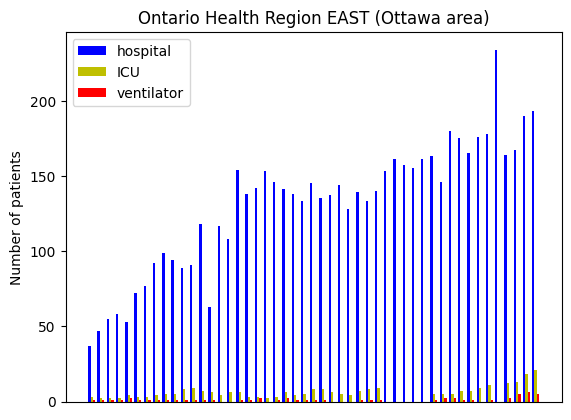

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tabulate import tabulate

hospitalizations_url = "https://data.ontario.ca/dataset/8f3a449b-bde5-4631-ada6-8bd94dbc7d15/resource/e760480e-1f95-4634-a923-98161cfb02fa/download/region_hospital_icu_covid_data.csv"
# hospitalizations_data = pd.read_csv(hospitalizations_url)
url_request_header = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}
hospitalizations_data = pd.read_csv( hospitalizations_url , storage_options = url_request_header )

# extract most recent number_of_items days of hospitalizations
# Ottawa is Ontario Health region EAST

desired_row = "EAST"
hospital_column = "hospitalizations"
hospital_label = 'hospital'
icu_column = "icu_current_covid"
icu_label = 'ICU'
ventilator_column = 'icu_current_covid_vented'
ventilator_label = 'ventilator'
number_of_items = 49
offset_width = 0.25

# extract only the rows matching desired_row (EAST)
selected_hospital_rows = hospitalizations_data.loc[hospitalizations_data['oh_region'] == desired_row]

# make a table
# using tabulate because otherwise it is wrapping the rows for some reason
print("Line number, Date,")
print("Hos = Hospitalizations")
print("IC = ICU current COVID-19")
print("IV = ICU current COVID-19 on ventilator")
print("- means Not a Number (a blank entry)")
print("\n")
print("line  YYYY-MM-DD  Hos  IC  IV")
print(tabulate(selected_hospital_rows[['date', hospital_column, icu_column, ventilator_column]].tail(number_of_items).replace(np.nan, None), missingval='-'))
print("\n")

# make a chart
r = np.arange(number_of_items) # just a set of index values for the plot

plt.bar( r , list(selected_hospital_rows[hospital_column].tail(number_of_items)), color ='b' , label = hospital_label, width = offset_width)
plt.bar( r + offset_width, list(selected_hospital_rows[icu_column].tail(number_of_items)), color ='y', label = icu_label, width = offset_width)
plt.bar( r + offset_width + offset_width, list(selected_hospital_rows[ventilator_column].tail(number_of_items)), color ='r', label = ventilator_label, width = offset_width)

plt.plot()

plt.ylabel("Number of patients")
plt.title("Ontario Health Region EAST (Ottawa area)")
plt.legend(loc="upper left")

# hide meaningless x-axis
ax = plt.gca()
ax.axes.xaxis.set_visible(False)

plt.show()